In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
processed_data_path = "processed_data/"

In [2]:
X_train = pd.read_csv(processed_data_path+"X_train.csv")
X_test = pd.read_csv(processed_data_path+"X_test.csv")
y_train = pd.read_csv(processed_data_path+"y_train.csv")
y_test = pd.read_csv(processed_data_path+"y_test.csv")
y_test = y_test.values.squeeze()

In [3]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   32950 non-null  float64
 1   education             32950 non-null  float64
 2   default               32950 non-null  float64
 3   housing               32950 non-null  float64
 4   loan                  32950 non-null  float64
 5   duration              32950 non-null  float64
 6   campaign              32950 non-null  float64
 7   pdays                 32950 non-null  float64
 8   previous              32950 non-null  float64
 9   emp.var.rate          32950 non-null  float64
 10  cons.price.idx        32950 non-null  float64
 11  cons.conf.idx         32950 non-null  float64
 12  euribor3m             32950 non-null  float64
 13  nr.employed           32950 non-null  float64
 14  poutcome_failure      32950 non-null  float64
 15  poutcome_nonexisten

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12)

In [5]:
train_data = X_train
train_data['y'] = y_train

#分离正负样本
pos_train_data = train_data[train_data['y'] == 1]
neg_train_data = train_data[train_data['y'] == 0]
pos_train_data.reset_index(drop = True, inplace = True)
neg_train_data.reset_index(drop = True, inplace = True)
#new_count = n * pos_train_data['y'].count()

In [6]:
print(pos_train_data.reset_index().head())
print(pos_train_data.reset_index().describe())

   index       age  education  default  housing  loan  duration  campaign  \
0      0  0.185185   0.500000      0.0      1.0   0.0  0.074780  0.000000   
1      1  0.172840   0.333333      0.0      1.0   0.0  0.036675  0.000000   
2      2  0.234568   0.666667      0.0      1.0   0.0  0.072398  0.000000   
3      3  0.185185   1.000000      0.0      0.0   0.0  0.088354  0.000000   
4      4  0.172840   0.833333      0.0      0.0   0.0  0.075732  0.018182   

      pdays  previous  ...  month_may  month_nov  month_oct  month_sep  \
0  0.000000  0.000000  ...        0.0        0.0        0.0        0.0   
1  0.000000  0.000000  ...        0.0        0.0        1.0        0.0   
2  0.142857  0.142857  ...        0.0        0.0        1.0        0.0   
3  0.000000  0.000000  ...        0.0        0.0        1.0        0.0   
4  0.000000  0.000000  ...        0.0        0.0        0.0        0.0   

   day_of_week_fri  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0              0.0 

In [7]:
from sklearn.neighbors import NearestNeighbors
import random

def smote_up_sample(data,N):    
    #近邻数k
    k = 3
    #选择用于评估样本点距离的特征
    feature = ['age', 'duration', 'campaign', 'pdays', 'previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed']

    #new_data用于存放插值得到的样本
    new_data = np.zeros((data.shape[0]*N,len(feature)))
    newdf = data.copy()

    neighbors = NearestNeighbors(n_neighbors=k).fit(data.loc[:,feature].values)
    for i in range(data.shape[0]):

        point = data.loc[i,feature]

        distances, indices = neighbors.kneighbors(point.values.reshape(1, -1))
        nn = random.randint(1,k-1)
        dis = data.loc[indices[0,nn],feature].values.reshape(1, -1) - data.loc[i,feature].values.reshape(1, -1)
        gap = random.random()
        new_data[i] = data.loc[i,feature].values.reshape(1, -1) + dis * gap
        newdf.loc[i,feature] = new_data[i]             
    data = pd.concat([data, newdf], ignore_index=True)
    return data

In [8]:
#对正样本进行过采样
pos_train_data = smote_up_sample(pos_train_data,N=2)
#对负样本进行欠采样
neg_train_data = neg_train_data.sample(frac = 0.5,random_state=42)
#重新拼接正负样本
train_data_sample = pd.concat([pos_train_data, neg_train_data],sort=False)

X_train = train_data_sample.drop(['y'],axis =1)
y_train = train_data_sample['y']

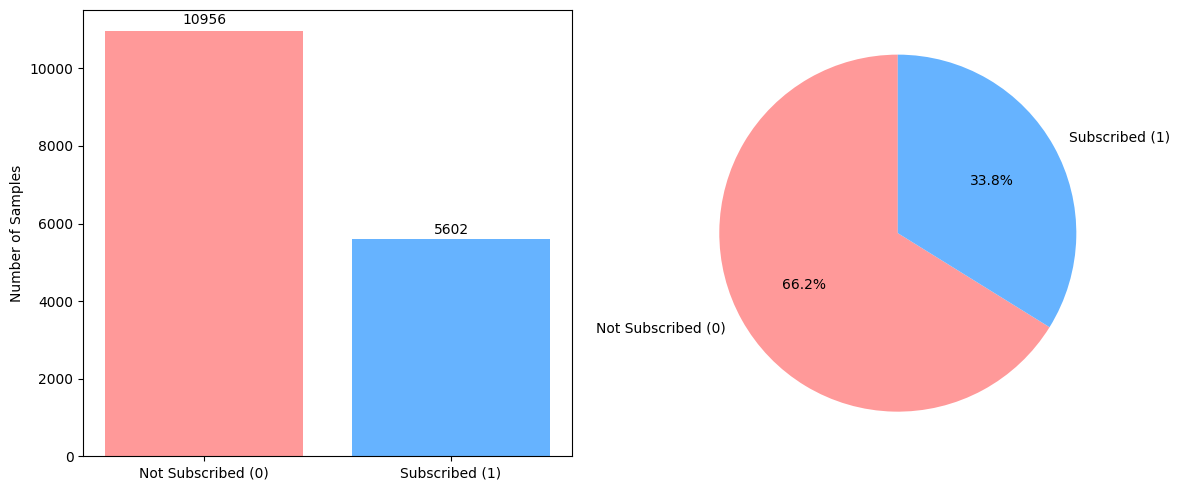

Sample counts after balancing:
  Not Subscribed (0): 10956
  Subscribed (1): 5602
  Ratio (1:0): 0.51


In [9]:
import matplotlib.pyplot as plt

y_train_counts = pd.Series(y_train).value_counts().sort_index()

# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- 左图：柱状图（显示绝对数量）---
bars = ax1.bar(['Not Subscribed (0)', 'Subscribed (1)'], y_train_counts.values, color=['#ff9999', '#66b3ff'])
ax1.set_ylabel('Number of Samples')
# 在柱子上添加具体数值
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + height*0.01, f'{int(height)}', ha='center', va='bottom')

# --- 右图：饼图（显示比例）---
ax2.pie(y_train_counts.values, labels=['Not Subscribed (0)', 'Subscribed (1)'], 
        autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.tight_layout()
plt.savefig('class_distribution_after_sampling.png', dpi=300, bbox_inches='tight')
plt.show()

print("Sample counts after balancing:")
print(f"  Not Subscribed (0): {y_train_counts.get(0, 0)}")
print(f"  Subscribed (1): {y_train_counts.get(1, 0)}")
print(f"  Ratio (1:0): {y_train_counts.get(1, 0) / y_train_counts.get(0, 1):.2f}")

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [11]:
# --- 1. 多重共线性检验 (基于 Spearman 相关系数) ---
print("--- Multicollinearity Check (Spearman Correlation) ---")

# 计算 Spearman 相关矩阵
# 对于独热编码后的特征，Spearman 与 Pearson 会得到相同结果，但 Spearman 更通用
correlation_matrix, _ = spearmanr(X_train)
# 转换为 DataFrame 便于查看和可视化
correlation_df = pd.DataFrame(correlation_matrix, index=X_train.columns, columns=X_train.columns)

# 找出相关性高于阈值的特征对
threshold = 0.8 # 设定相关性阈值
high_corr_pairs = []
for i in range(len(correlation_df.columns)):
    for j in range(i+1, len(correlation_df.columns)):
        if abs(correlation_df.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_df.columns[i], correlation_df.columns[j], correlation_df.iloc[i, j]))

if high_corr_pairs:
    print(f"Features with absolute Spearman correlation > {threshold}:")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} - {feat2}: {corr:.3f}")
else:
    print(f"No feature pairs found with absolute Spearman correlation > {threshold}.")

--- Multicollinearity Check (Spearman Correlation) ---
Features with absolute Spearman correlation > 0.8:
  pdays - poutcome_success: 0.941
  previous - poutcome_nonexistent: -0.996
  emp.var.rate - euribor3m: 0.919
  emp.var.rate - nr.employed: 0.909
  euribor3m - nr.employed: 0.946
  contact_cellular - contact_telephone: -1.000


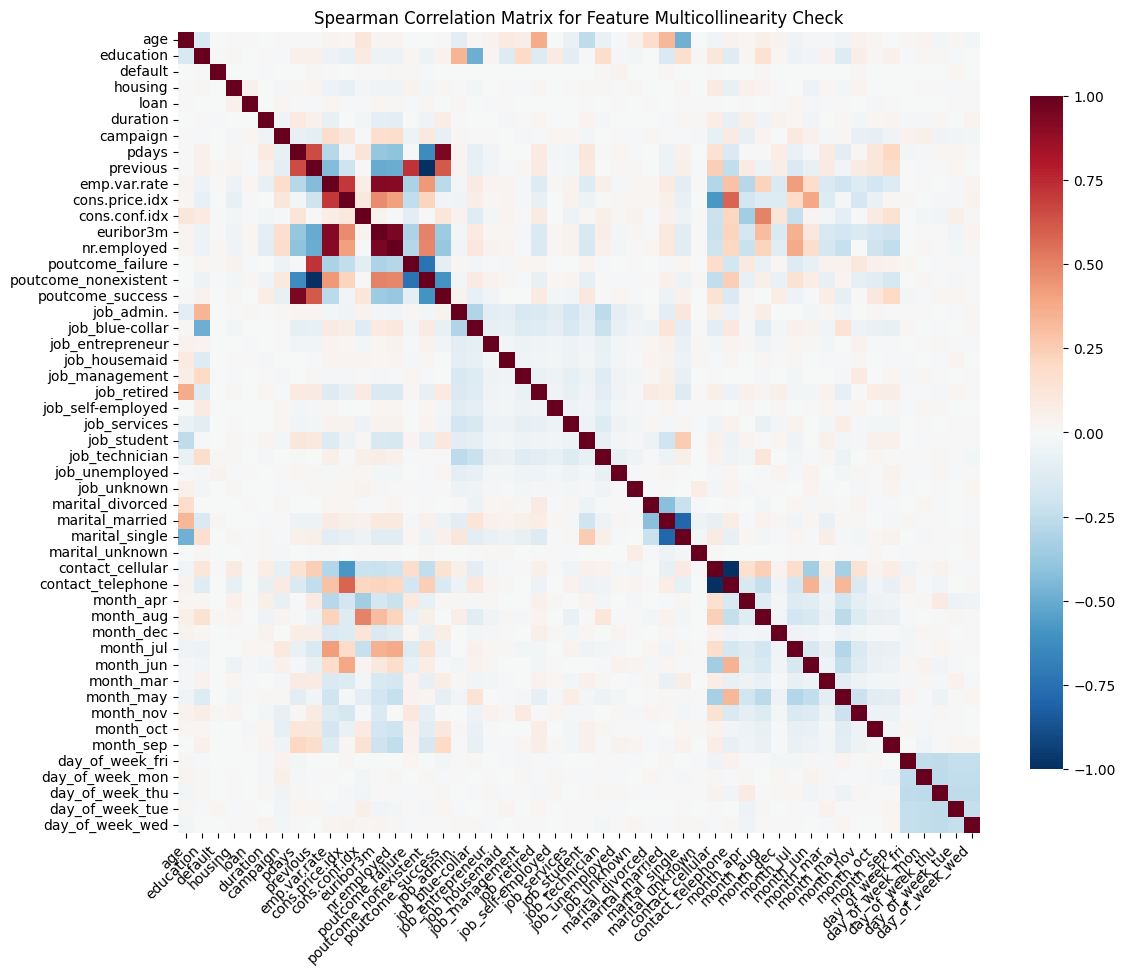

In [12]:
# --- 2. 绘制相关性热力图 ---
# 设置图形大小
plt.figure(figsize=(12, 10)) # 根据特征数量调整大小

# 绘制热力图
sns.heatmap(
    correlation_df,
    annot=False,  # 不在图上显示具体数值，避免过于杂乱
    cmap='RdBu_r', # 使用红-白-蓝渐变，0 为中心
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": .8}
)
plt.title('Spearman Correlation Matrix for Feature Multicollinearity Check')
plt.xticks(rotation=45, ha="right") # 旋转 x 轴标签
plt.yticks(rotation=0) # y 轴标签通常不需要旋转
plt.tight_layout()
plt.savefig('correlation_matrix_check.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import warnings
warnings.filterwarnings("ignore")

In [15]:
# 定义评估指标（针对不平衡数据，使用 F1-score）
scoring_metric = make_scorer(f1_score, average='binary')  # 二分类，关注正例

# 存储最终最优模型及其搜索对象
best_models = {}
search_objects = {} # 用于存储 RandomizedSearchCV 对象，以获取其 best_params_

In [16]:
# ----------------------------
# 1. 决策树 (Decision Tree)
# ----------------------------
print("Tuning Decision Tree...")
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
dt_search = RandomizedSearchCV(
    dt, dt_params, n_iter=20, scoring=scoring_metric,
    cv=3, random_state=42, n_jobs=-1, verbose=0
)
dt_search.fit(X_train, y_train)
best_models['DecisionTree'] = dt_search.best_estimator_
search_objects['DecisionTree'] = dt_search
print(f"  Best params: {dt_search.best_params_}")

Tuning Decision Tree...
  Best params: {'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}


In [17]:
# ----------------------------
# 2. 随机森林 (Random Forest)
# ----------------------------
print("Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42, oob_score=True)
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=30, scoring=scoring_metric,
    cv=3, random_state=42, n_jobs=-1, verbose=0
)
rf_search.fit(X_train, y_train)
best_models['RandomForest'] = rf_search.best_estimator_
search_objects['RandomForest'] = rf_search
print(f"  Best params: {rf_search.best_params_}")

Tuning Random Forest...
  Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


In [20]:
# ----------------------------
# 3. AdaBoost
# ----------------------------
print("Tuning AdaBoost...")
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3] # AdaBoost 通常用浅树或树桩
}
# 使用决策树桩作为基学习器
base_estimator = DecisionTreeClassifier(random_state=42)
ada = AdaBoostClassifier(estimator=base_estimator, random_state=42)
ada_search = RandomizedSearchCV(
    ada, ada_params, n_iter=20, scoring=scoring_metric,
    cv=3, random_state=42, n_jobs=-1, verbose=0
)
ada_search.fit(X_train, y_train)
best_models['AdaBoost'] = ada_search.best_estimator_
search_objects['AdaBoost'] = ada_search
print(f"  Best params: {ada_search.best_params_}")

Tuning AdaBoost...
  Best params: {'n_estimators': 100, 'learning_rate': 1.0, 'estimator__max_depth': 3}


In [21]:
# ----------------------------
# 4. 梯度提升树 (Gradient Boosting)
# ----------------------------
print("Tuning Gradient Boosting...")
gb_params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}
gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    gb, gb_params, n_iter=30, scoring=scoring_metric,
    cv=3, random_state=42, n_jobs=-1, verbose=0
)
gb_search.fit(X_train, y_train)
best_models['GradientBoosting'] = gb_search.best_estimator_
search_objects['GradientBoosting'] = gb_search
print(f"  Best params: {gb_search.best_params_}")

Tuning Gradient Boosting...
  Best params: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.1}


In [22]:
# ----------------------------
# 5. XGBoost
# ----------------------------
print("Tuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=30, scoring=scoring_metric,
    cv=3, random_state=42, n_jobs=-1, verbose=0
)
xgb_search.fit(X_train, y_train)
best_models['XGBoost'] = xgb_search.best_estimator_
search_objects['XGBoost'] = xgb_search
print(f"  Best params: {xgb_search.best_params_}")

Tuning XGBoost...
  Best params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [23]:
# ----------------------------
# 6. LightGBM
# ----------------------------
print("Tuning LightGBM...")
lgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, -1],  # -1 表示无限制
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 50]
}
lgb = LGBMClassifier(random_state=42, verbose=-1)
lgb_search = RandomizedSearchCV(
    lgb, lgb_params, n_iter=30, scoring=scoring_metric,
    cv=3, random_state=42, n_jobs=-1, verbose=0
)
lgb_search.fit(X_train, y_train)
best_models['LightGBM'] = lgb_search.best_estimator_
search_objects['LightGBM'] = lgb_search
print(f"  Best params: {lgb_search.best_params_}")

Tuning LightGBM...
  Best params: {'subsample': 0.8, 'num_leaves': 127, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [24]:
# --- 打印最终模型的超参数 ---
print("\n--- Final Optimized Model Hyperparameters ---")
for name, model in best_models.items():
    print(f"\n{name}:")
    # 从对应的搜索对象中获取最佳参数
    best_params = search_objects[name].best_params_
    for param, value in best_params.items():
        print(f"  {param}: {value}")


--- Final Optimized Model Hyperparameters ---

DecisionTree:
  min_samples_split: 20
  min_samples_leaf: 1
  max_depth: 10
  criterion: gini

RandomForest:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: None
  bootstrap: True

AdaBoost:
  n_estimators: 100
  learning_rate: 1.0
  estimator__max_depth: 3

GradientBoosting:
  subsample: 0.8
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 4
  max_depth: 6
  learning_rate: 0.1

XGBoost:
  subsample: 1.0
  n_estimators: 300
  max_depth: 3
  learning_rate: 0.1
  gamma: 0.1
  colsample_bytree: 0.8

LightGBM:
  subsample: 0.8
  num_leaves: 127
  n_estimators: 300
  min_child_samples: 10
  max_depth: -1
  learning_rate: 0.2
  colsample_bytree: 1.0


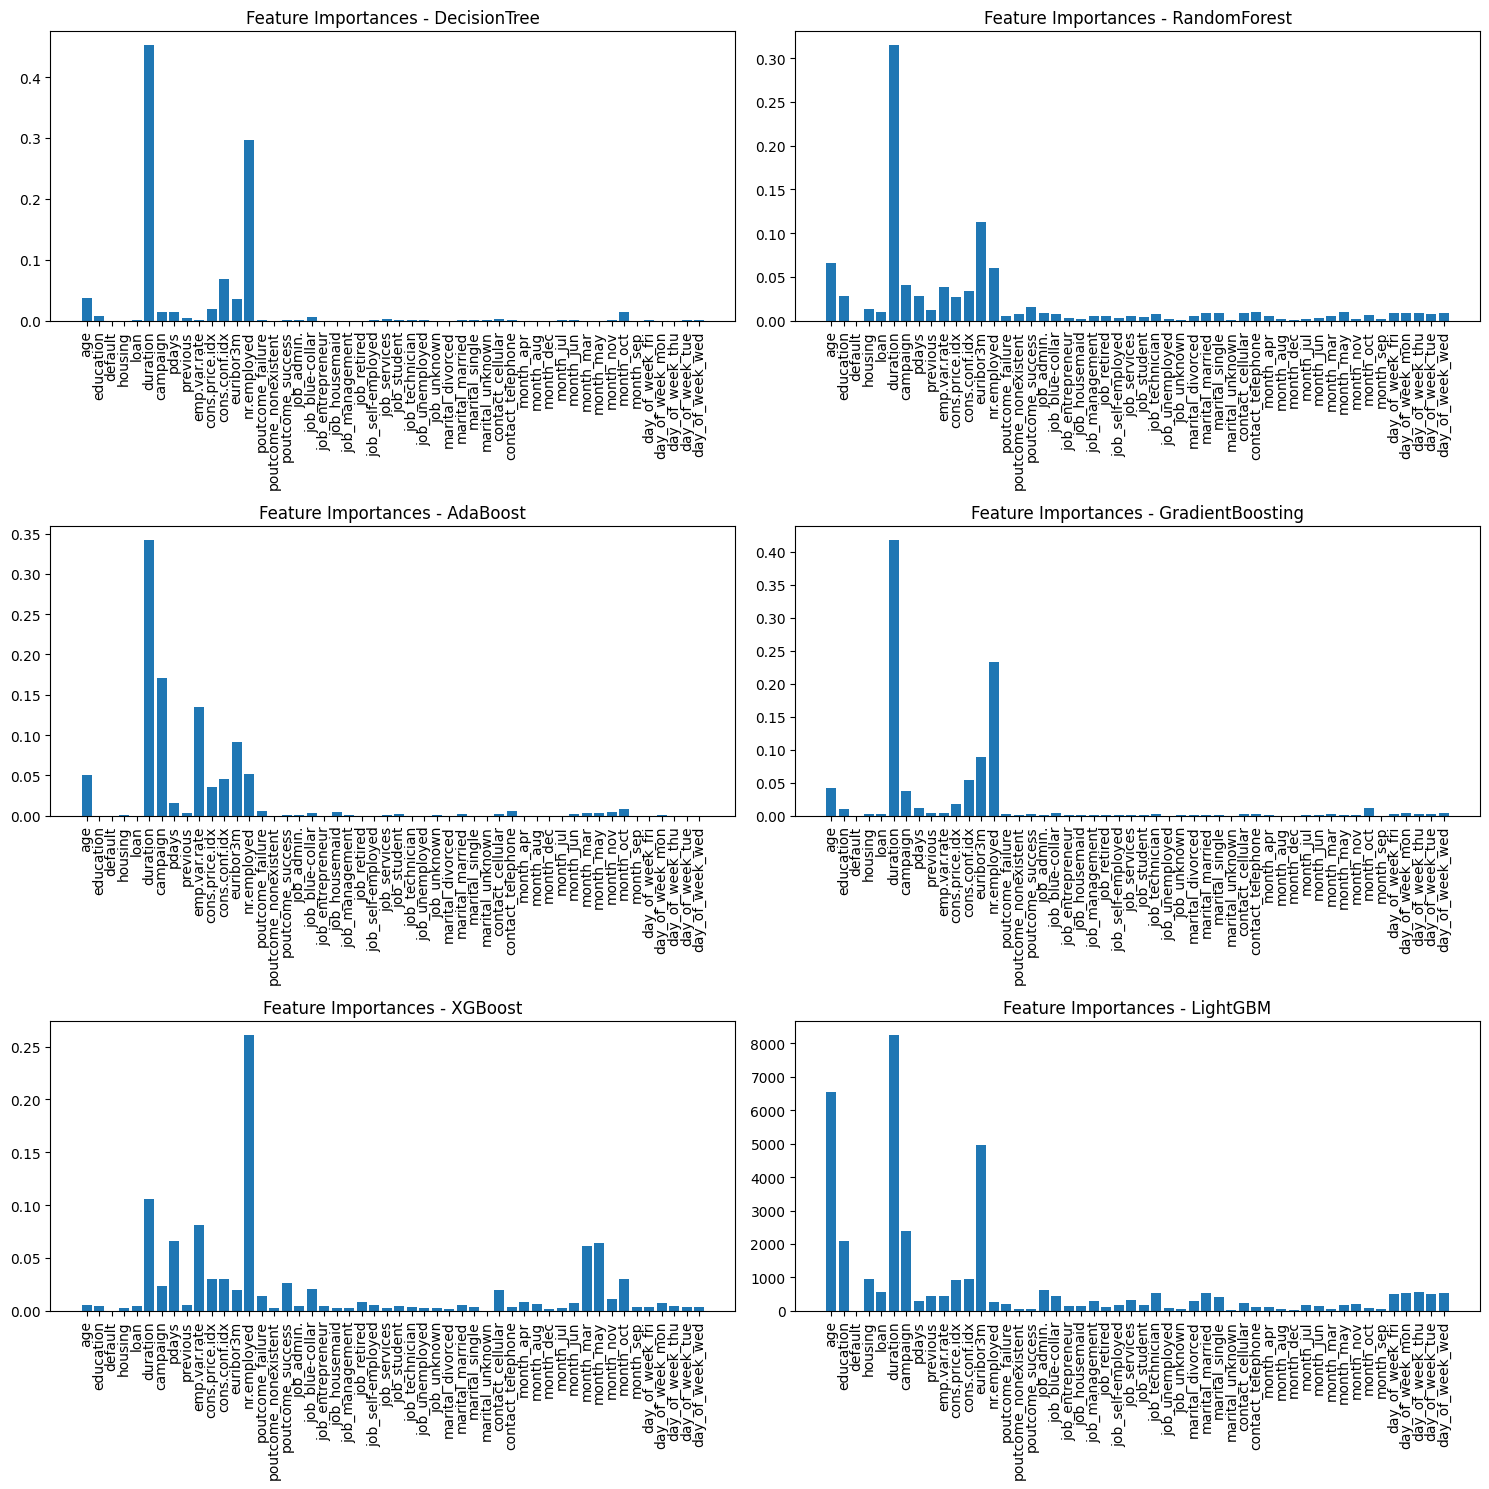

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 best_models 字典已包含所有最优模型
models_to_plot = ['DecisionTree', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'XGBoost', 'LightGBM']
n_models = len(models_to_plot)

# 计算需要多少行和列来排版子图
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
# 如果只有一个模型，axes 不是数组，需要处理
if n_models == 1:
    axes = [axes]
elif n_rows == 1 and n_cols == 1:
    axes = [axes]
else:
    axes = axes.flatten() # 将多维数组展平为一维，方便索引

for i, model_name in enumerate(models_to_plot):
    model = best_models[model_name]
    importances = model.feature_importances_
    feature_names = X_train.columns

    # 在对应的子图上绘制
    axes[i].bar(feature_names, importances)
    axes[i].set_title(f'Feature Importances - {model_name}')
    axes[i].tick_params(axis='x', rotation=90) # 旋转 x 轴标签

# 如果子图数量多于模型数量，隐藏多余的子图
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

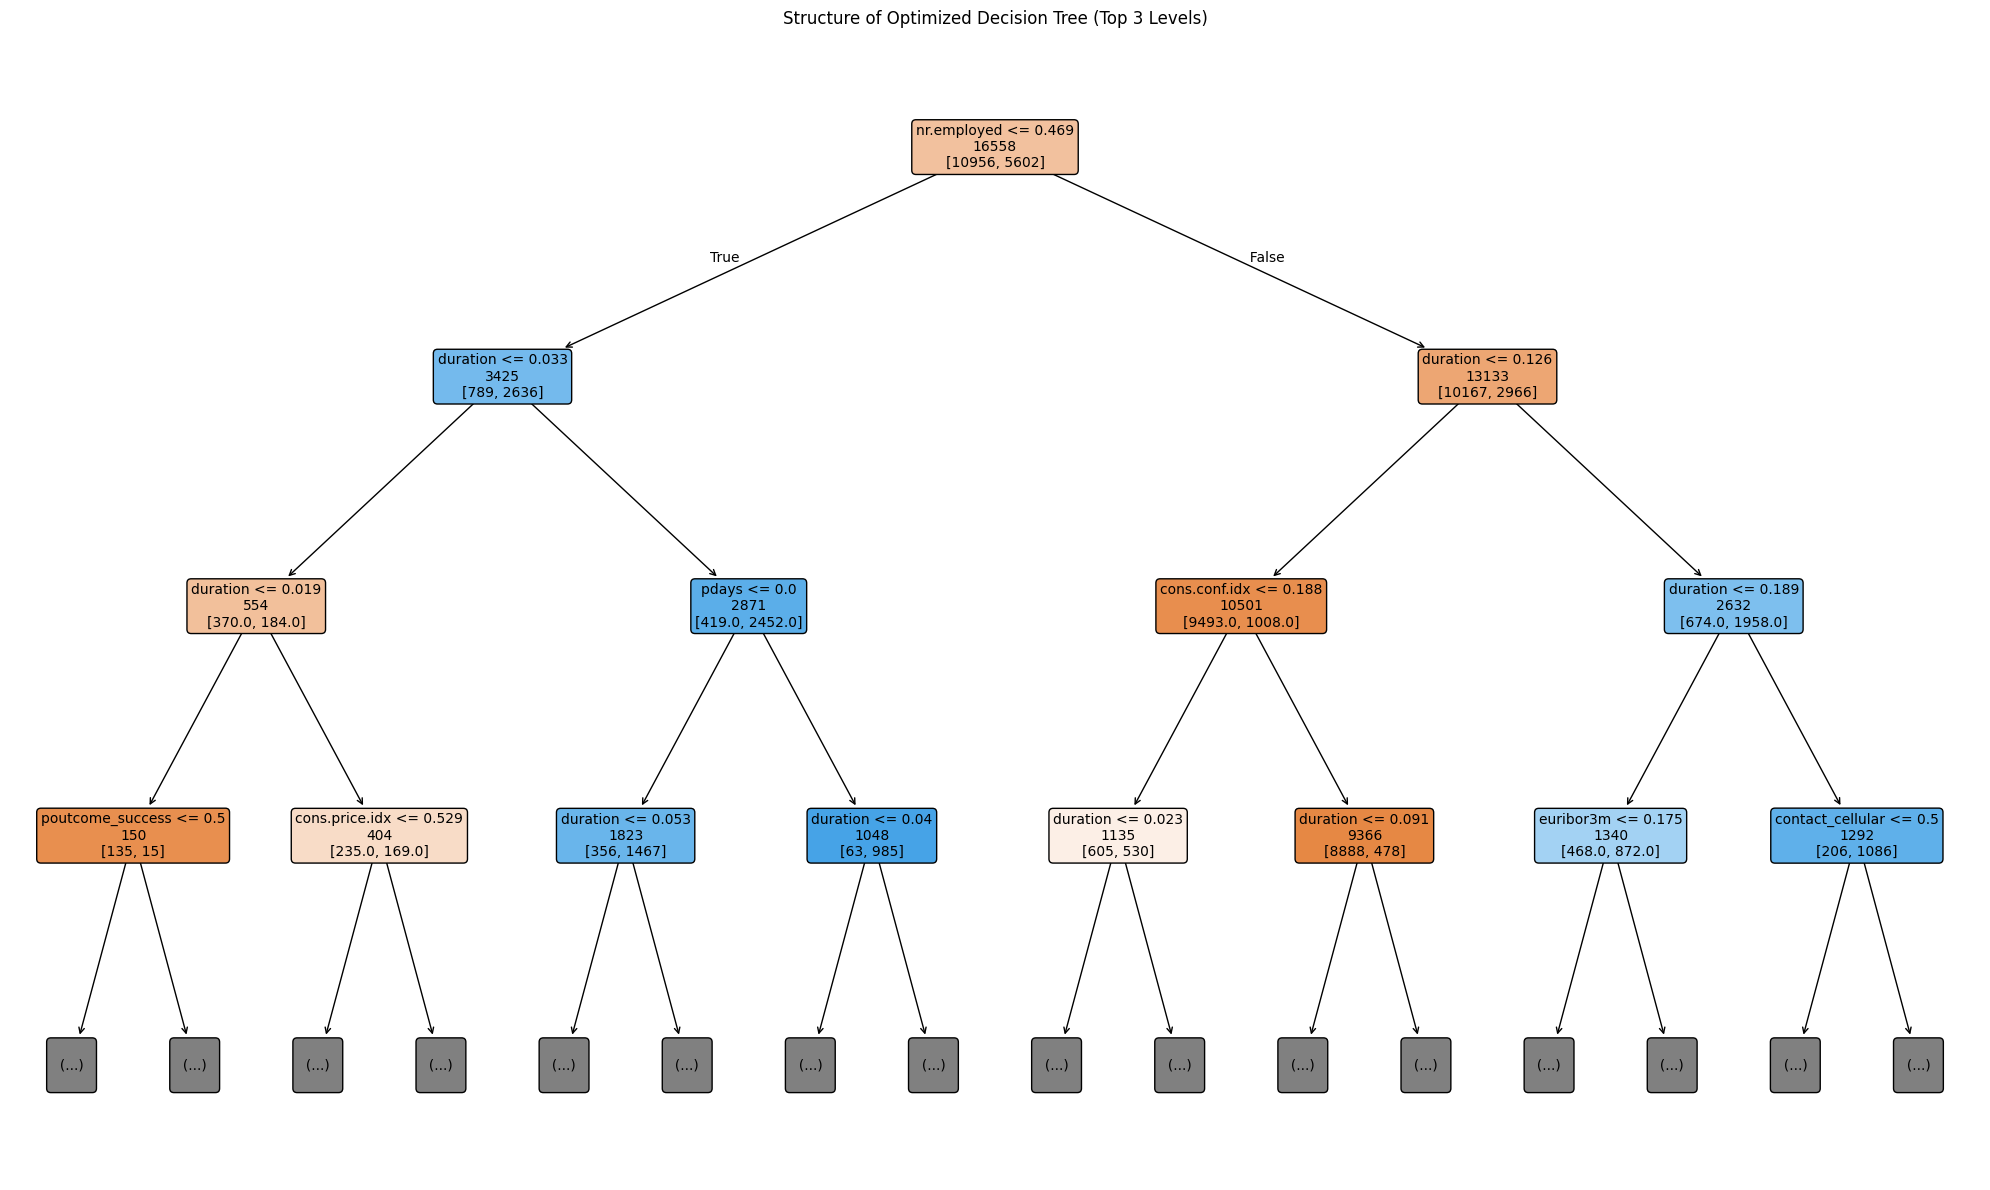

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 假设 dt_best 是最优的决策树模型
dt_best = best_models['DecisionTree']

# 选择一个较小的 max_depth 来可视化（例如，只看前3层）
max_depth_to_show = 3 # 可以根据需要调整

plt.figure(figsize=(20, 12)) # 根据 max_depth 调整图形尺寸
plot_tree(dt_best, 
          feature_names=X_train.columns, # 特征名
          # class_names=['Not Subscribed', 'Subscribed'], # 可选：显示类别名
          filled=True, # 用颜色填充节点（可选）
          rounded=True, # 圆角矩形（可选）
          fontsize=10, # 字体大小
          impurity=False,  # 不显示不纯度
          proportion=False, # 不显示比例（显示样本数）
          label='none', # 只显示特征和划分条件，不显示其他信息
          max_depth=max_depth_to_show # 只显示树的前 max_depth_to_show 层
          )
plt.title(f"Structure of Optimized Decision Tree (Top {max_depth_to_show} Levels)")
plt.tight_layout() # 自动调整布局
plt.show()

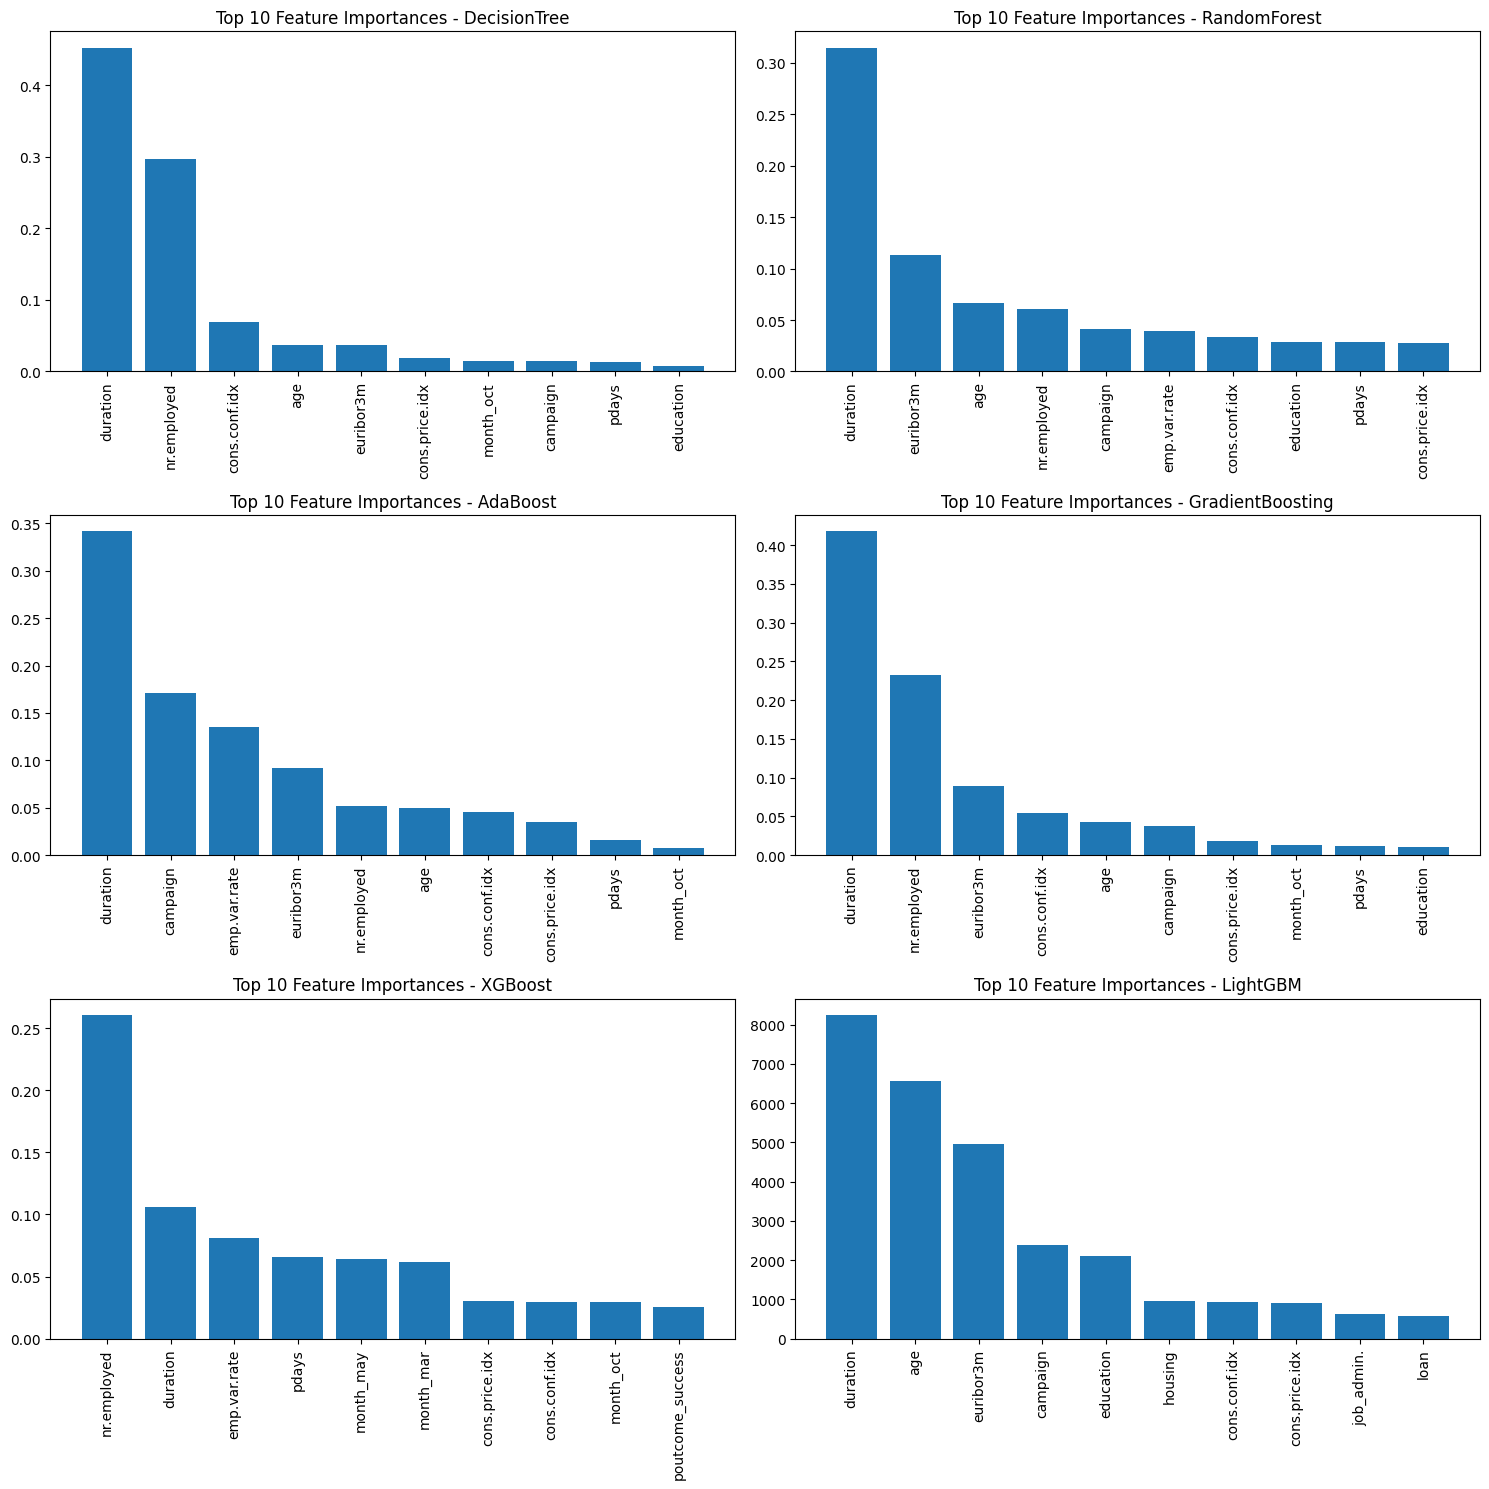

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 假设 best_models 字典已包含所有最优模型
models_to_plot = ['DecisionTree', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'XGBoost', 'LightGBM']
n_models = len(models_to_plot)

# 计算需要多少行和列来排版子图
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_rows * n_cols > 1 else [axes] # 确保 axes 是一个列表

for i, model_name in enumerate(models_to_plot):
    model = best_models[model_name]
    importances = model.feature_importances_
    feature_names = X_train.columns

    # 创建一个 Series 并排序，取前 10 个
    importances_series = pd.Series(importances, index=feature_names)
    top_10_importances = importances_series.nlargest(10)

    # 在对应的子图上绘制
    axes[i].bar(top_10_importances.index, top_10_importances.values)
    axes[i].set_title(f'Top 10 Feature Importances - {model_name}')
    axes[i].tick_params(axis='x', rotation=90) # 旋转 x 轴标签

# 如果子图数量多于模型数量，隐藏多余的子图
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import pandas as pd
import numpy as np

# 计算每个模型的预测结果
model_names = list(best_models.keys())
y_test_preds = {name: model.predict(X_test) for name, model in best_models.items()}
# 对于 AUC，需要预测概率
y_test_probas = {name: model.predict_proba(X_test)[:, 1] for name, model in best_models.items()}

# 初始化结果字典
results_dict = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC-ROC': []
}

for name in model_names:
    y_pred = y_test_preds[name]
    y_proba = y_test_probas[name]
    
    results_dict['Model'].append(name)
    results_dict['Accuracy'].append(accuracy_score(y_test, y_pred))
    results_dict['Precision'].append(precision_score(y_test, y_pred, zero_division=0)) # 处理可能出现的除零错误
    results_dict['Recall'].append(recall_score(y_test, y_pred))
    results_dict['F1-Score'].append(f1_score(y_test, y_pred))
    results_dict['AUC-ROC'].append(roc_auc_score(y_test, y_proba))

# 转换为 DataFrame 便于查看和展示
results_df = pd.DataFrame(results_dict)
print(results_df.round(4)) # 保留四位小数

              Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0      DecisionTree    0.8847     0.4793  0.6845    0.5638   0.8807
1      RandomForest    0.9016     0.5351  0.7302    0.6176   0.9340
2          AdaBoost    0.8765     0.4607  0.7848    0.5806   0.9265
3  GradientBoosting    0.8631     0.4317  0.8138    0.5641   0.9253
4           XGBoost    0.8575     0.4229  0.8473    0.5642   0.9251
5          LightGBM    0.8756     0.4577  0.7715    0.5745   0.9250


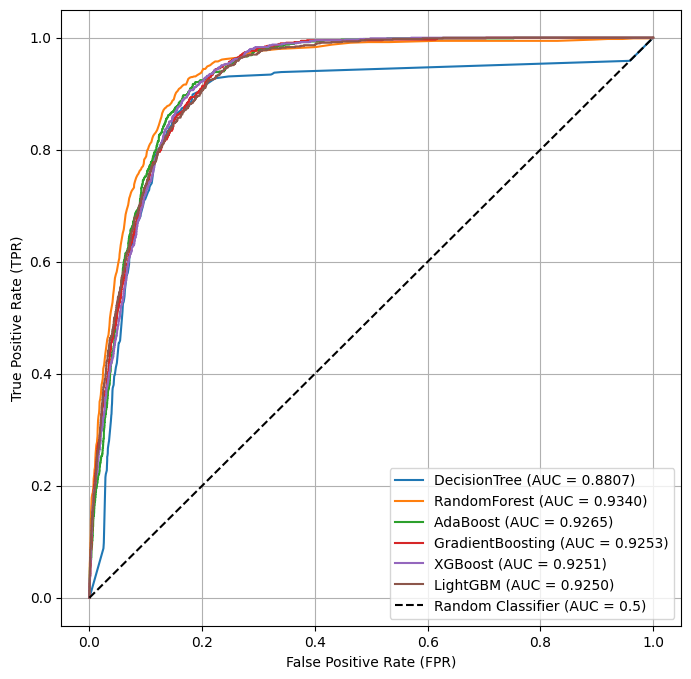

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 8))
for name in model_names:
    y_proba = y_test_probas[name]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid(True)
plt.show()

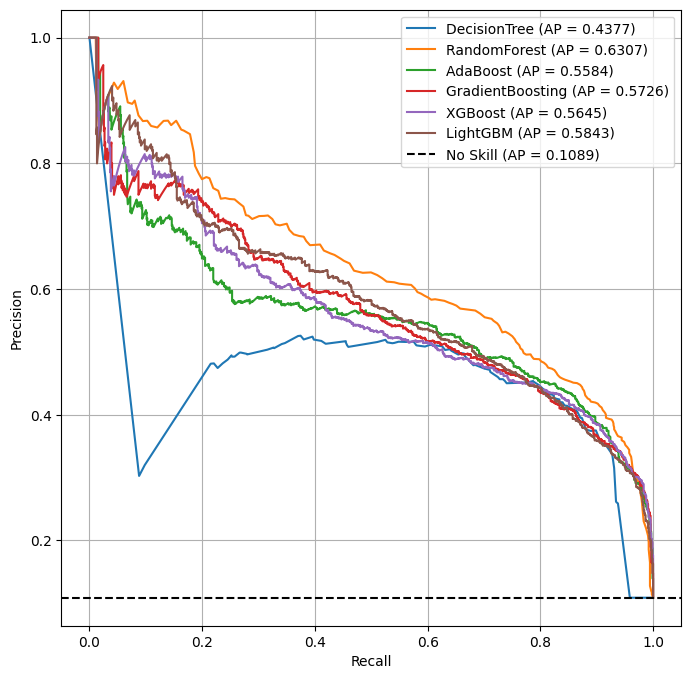

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 8))
for name in model_names:
    y_proba = y_test_probas[name]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.4f})')

# 注意：PR 图的 baseline 是正例比例
no_skill = len(y_test[y_test==1]) / len(y_test) # 正例比例
plt.axhline(y=no_skill, color='k', linestyle='--', label=f'No Skill (AP = {no_skill:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall Curves Comparison')
plt.legend()
plt.grid(True)
# plt.savefig('pr_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

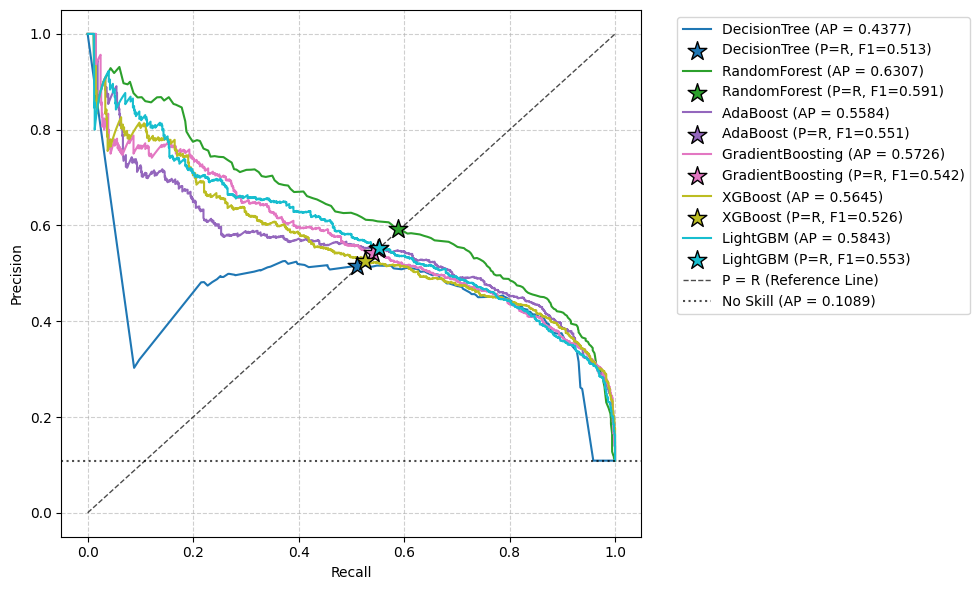

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

plt.figure(figsize=(10, 6))
# 预定义颜色，以便区分
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

for idx, name in enumerate(model_names):
    y_proba = y_test_probas[name]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    # 寻找 P = R 的交点
    # 计算 |P - R| 的绝对差值
    diff_pr = np.abs(precision - recall)
    # 找到差值最小的索引（最接近 P=R 的点）
    # 注意：precision 和 recall 的最后一个值是 (0, 1)，第一个值是 (1, 0)，通常不考虑 P=R 的情况在这些边界点
    # 我们寻找中间部分最接近的点
    min_diff_idx = np.argmin(diff_pr[:-1]) # 排除最后一个点 (0, 1)
    equilibrium_recall = recall[min_diff_idx]
    equilibrium_precision = precision[min_diff_idx]
    equilibrium_f1 = 2 * (equilibrium_precision * equilibrium_recall) / (equilibrium_precision + equilibrium_recall + 1e-8) # 计算该点的 F1

    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.4f})', color=colors[idx])
    # 标记 P=R 交点
    plt.scatter(equilibrium_recall, equilibrium_precision, marker='*', s=200, color=colors[idx], edgecolors='black', zorder=5, 
                label=f'{name} (P=R, F1={equilibrium_f1:.3f})')

# 绘制 P = R 的参考线 (y=x)
plt.plot([0, 1], [0, 1], 'k--', label='P = R (Reference Line)', linewidth=1, alpha=0.7)

# 注意：PR 图的 baseline 是正例比例
no_skill = len(y_test[y_test==1]) / len(y_test) # 正例比例
plt.axhline(y=no_skill, color='k', linestyle=':', label=f'No Skill (AP = {no_skill:.4f})', alpha=0.7)

plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall Curves Comparison with P=R Points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 调整图例位置，避免遮挡
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # 自动调整布局
# plt.savefig('pr_curves_comparison_with_p_eq_r.png', dpi=300, bbox_inches='tight') # 保存图片
plt.show()

In [43]:
# 假设：成功营销一个客户收益为 R，给非客户打电话成本为 C_fp，漏掉客户机会成本为 C_fn
# 这些值需要根据业务知识设定
R = 100  # 收益
C_fp = 10 # 误报成本
C_fn = 80 # 漏报成本 (通常 R > C_fn > C_fp)

cost_matrix = {
    'TP': R,    # 正确预测，获得收益
    'TN': 0,    # 正确预测，无成本收益
    'FP': -C_fp, # 误报，付出成本
    'FN': -C_fn  # 漏报，付出机会成本
}

def calculate_profit(y_true, y_pred, cost_matrix):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_profit = (tp * cost_matrix['TP'] +
                    tn * cost_matrix['TN'] +
                    fp * cost_matrix['FP'] +
                    fn * cost_matrix['FN'])
    return total_profit

# 计算每个模型的利润
profits = {}
for name, y_pred in y_test_preds.items():
    profit = calculate_profit(y_test, y_pred, cost_matrix)
    profits[name] = profit
    print(f"{name}: Estimated Profit = {profit:.2f}")

# 可以进一步计算单位样本的平均利润
n_samples = len(y_test)
avg_profits = {k: v/n_samples for k, v in profits.items()}
print("\nAverage Profit per Sample:")
for name, avg_profit in avg_profits.items():
    print(f"{name}: {avg_profit:.4f}")

# 选择利润最高的模型
best_model_by_profit = max(profits, key=profits.get)
print(f"\nModel with highest estimated profit: {best_model_by_profit}")

DecisionTree: Estimated Profit = 32090.00
RandomForest: Estimated Profit = 40450.00
AdaBoost: Estimated Profit = 46720.00
GradientBoosting: Estimated Profit = 50030.00
XGBoost: Estimated Profit = 54670.00
LightGBM: Estimated Profit = 44600.00

Average Profit per Sample:
DecisionTree: 3.8954
RandomForest: 4.9102
AdaBoost: 5.6713
GradientBoosting: 6.0731
XGBoost: 6.6363
LightGBM: 5.4139

Model with highest estimated profit: XGBoost


In [44]:
from scipy import stats

def calculate_ks_statistic(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    # KS = max(TPR - FPR)
    ks_stat = max(tpr - fpr)
    return ks_stat

ks_scores = {}
for name, y_proba in y_test_probas.items():
    ks_score = calculate_ks_statistic(y_test, y_proba)
    ks_scores[name] = ks_score
    print(f"{name}: KS Statistic = {ks_score:.4f}")

# 选择 KS 统计量最高的模型
best_model_by_ks = max(ks_scores, key=ks_scores.get)
print(f"\nModel with highest KS statistic: {best_model_by_ks}")

DecisionTree: KS Statistic = 0.7156
RandomForest: KS Statistic = 0.7511
AdaBoost: KS Statistic = 0.7340
GradientBoosting: KS Statistic = 0.7204
XGBoost: KS Statistic = 0.7289
LightGBM: KS Statistic = 0.7125

Model with highest KS statistic: RandomForest


DecisionTree - Top 10% Gain: 0.468, Top 10% Lift: 4.687
RandomForest - Top 10% Gain: 0.559, Top 10% Lift: 5.591
AdaBoost - Top 10% Gain: 0.513, Top 10% Lift: 5.133
GradientBoosting - Top 10% Gain: 0.512, Top 10% Lift: 5.122
XGBoost - Top 10% Gain: 0.494, Top 10% Lift: 4.943
LightGBM - Top 10% Gain: 0.522, Top 10% Lift: 5.222


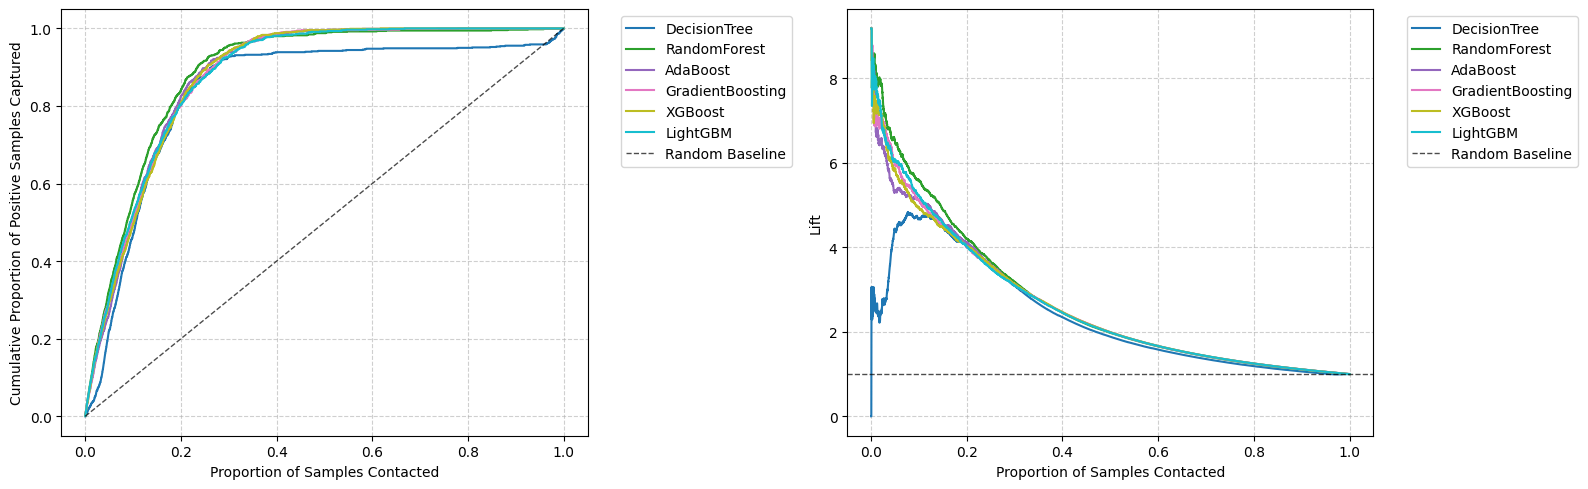

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# 准备绘图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# 预定义颜色，以便区分
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

for idx, name in enumerate(model_names):
    y_proba = y_test_probas[name]
    # 按预测概率降序排列
    desc_score_indices = np.argsort(y_proba)[::-1]
    y_true_sorted = y_test[desc_score_indices]
    # y_proba_sorted = y_proba[desc_score_indices] # 如果需要，可以保留排序后的概率

    # 计算累积正例数和总正例数
    cum_positive = np.cumsum(y_true_sorted)
    total_positive = np.sum(y_test) # 使用 y_test 全局变量计算总正例数
    total_samples = len(y_test) # 使用 y_test 全局变量计算总样本数

    # 计算增益（累积捕获的正例比例）
    gain = cum_positive / total_positive
    # 计算提升度（累积捕获的正例比例 / 累积接触的样本比例）
    proportion_contacted = np.arange(1, total_samples + 1) / total_samples
    lift = gain / proportion_contacted

    # 在子图1上绘制增益图
    ax1.plot(proportion_contacted, gain, label=f'{name}', color=colors[idx])
    # 在子图2上绘制提升度图
    ax2.plot(proportion_contacted, lift, label=f'{name}', color=colors[idx])

    # 计算 Top-N% 的指标（可选，用于打印或进一步分析）
    top_10_percent_idx = int(0.1 * total_samples)
    top_10_gain = gain[top_10_percent_idx - 1] # -1 for 0-based indexing
    top_10_lift = lift[top_10_percent_idx - 1]
    print(f"{name} - Top 10% Gain: {top_10_gain:.3f}, Top 10% Lift: {top_10_lift:.3f}")

# --- 增益图设置 ---
ax1.plot([0, 1], [0, 1], 'k--', label='Random Baseline', linewidth=1, alpha=0.7)
ax1.set_xlabel('Proportion of Samples Contacted')
ax1.set_ylabel('Cumulative Proportion of Positive Samples Captured')
# ax1.set_title('Gain Chart Comparison')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 调整图例位置
ax1.grid(True, linestyle='--', alpha=0.6)

# --- 提升度图设置 ---
ax2.axhline(y=1, color='k', linestyle='--', label='Random Baseline', linewidth=1, alpha=0.7)
ax2.set_xlabel('Proportion of Samples Contacted')
ax2.set_ylabel('Lift')
# ax2.set_title('Lift Chart Comparison')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 调整图例位置
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
# 保存图片
# plt.savefig('gain_lift_charts_comparison_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

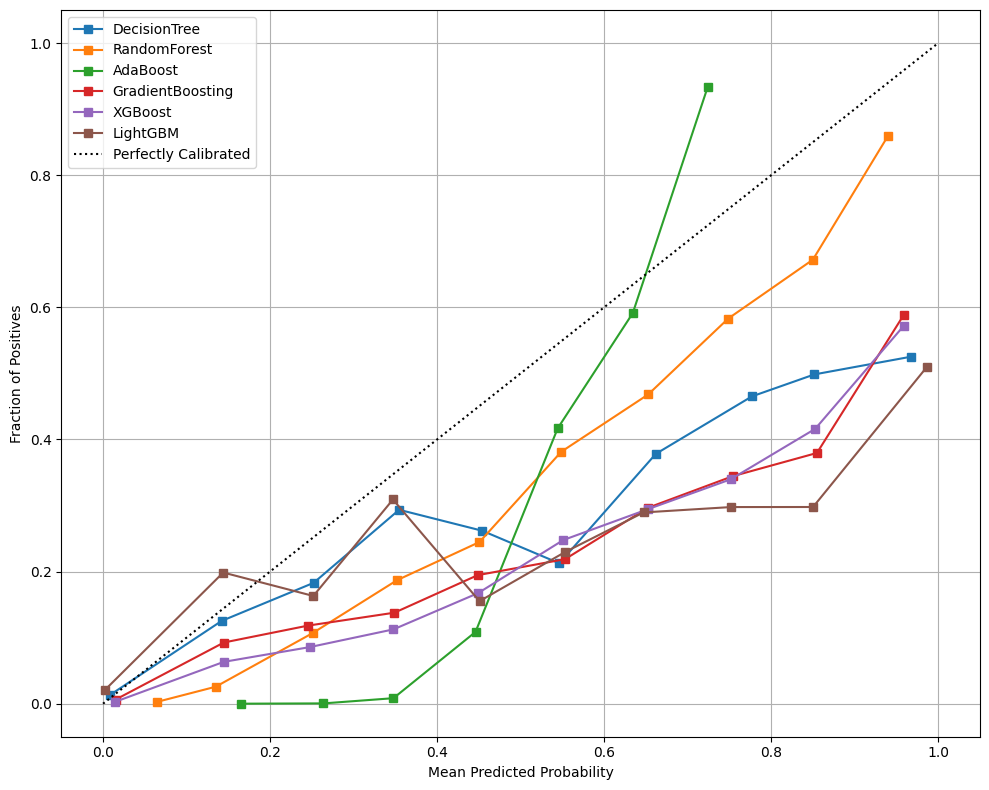

In [46]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for name, y_proba in y_test_probas.items():
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_proba, n_bins=10
    )
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

# 绘制理想校准线 (y=x)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
# plt.title("Calibration Curves Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('calibration_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


--- DecisionTree ---


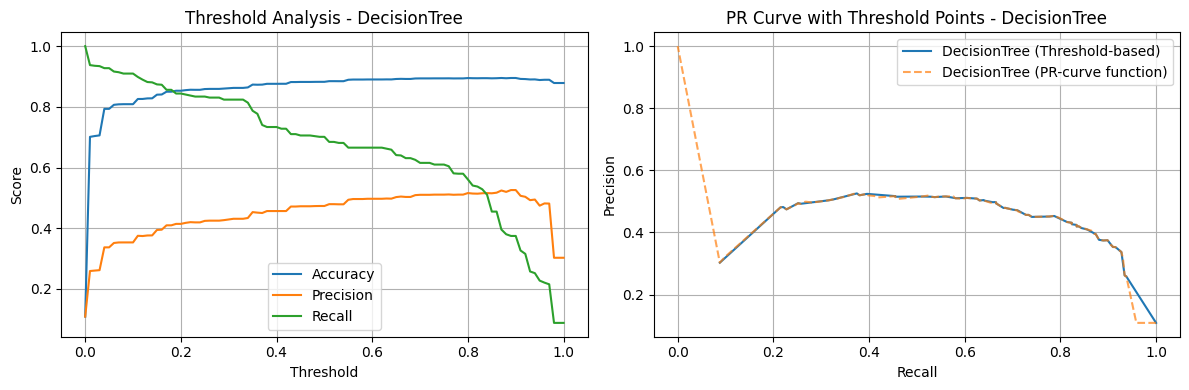

  Best F1-Score (0.5752) achieved at threshold: 0.350

--- RandomForest ---


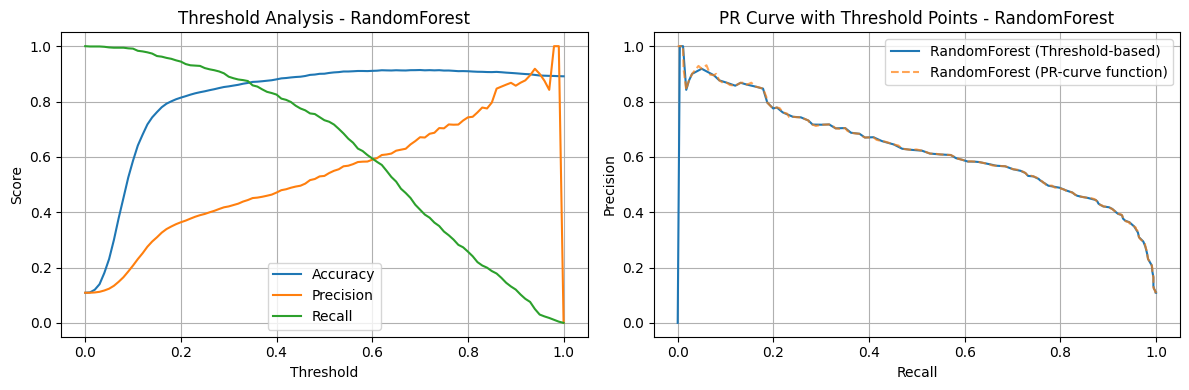

  Best F1-Score (0.6222) achieved at threshold: 0.520

--- AdaBoost ---


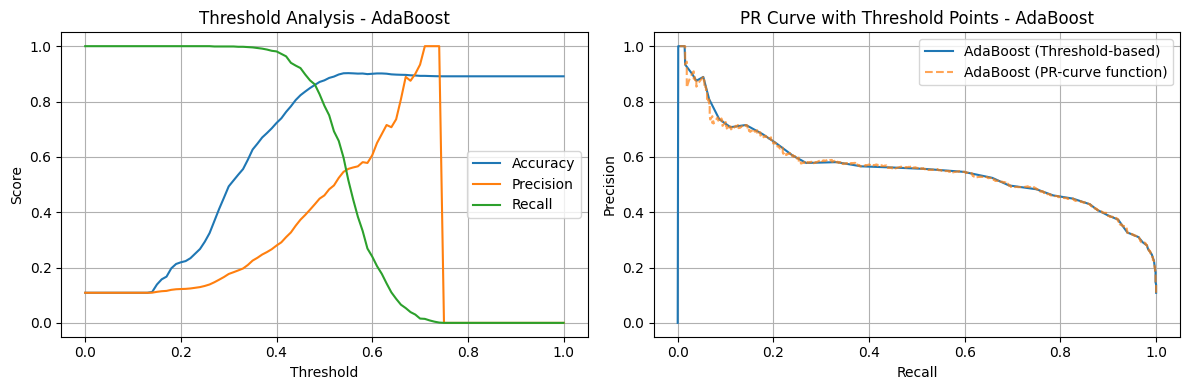

  Best F1-Score (0.5875) achieved at threshold: 0.510

--- GradientBoosting ---


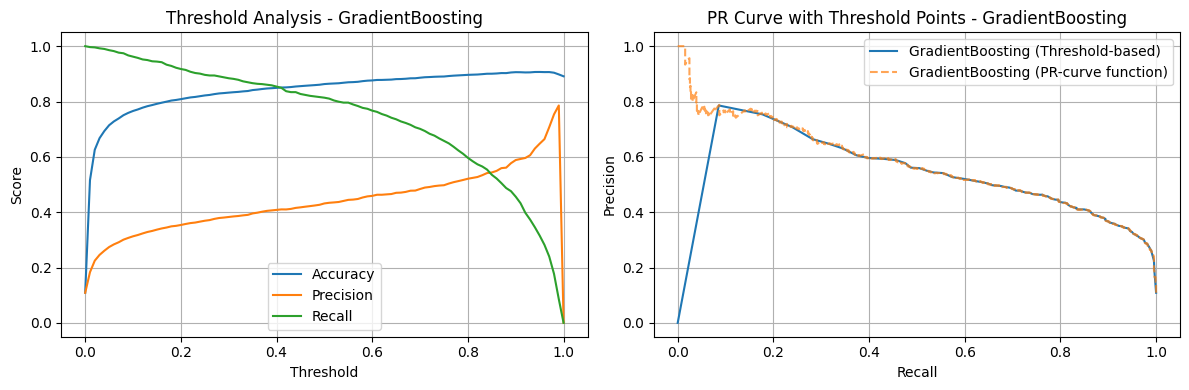

  Best F1-Score (0.5762) achieved at threshold: 0.610

--- XGBoost ---


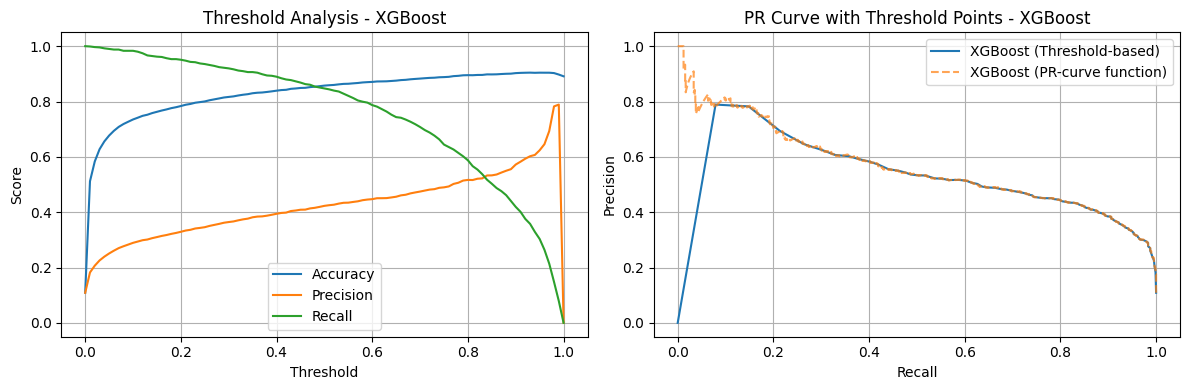

  Best F1-Score (0.5715) achieved at threshold: 0.610

--- LightGBM ---


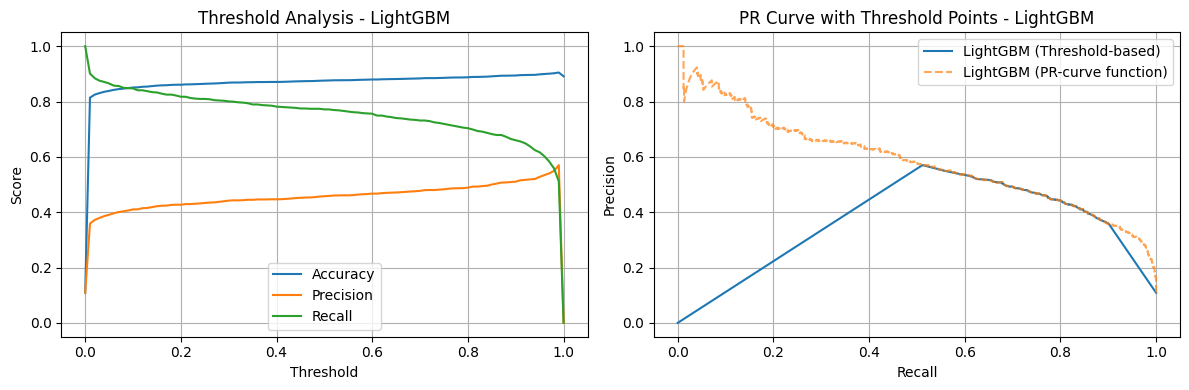

  Best F1-Score (0.5806) achieved at threshold: 0.870


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score

def plot_threshold_analysis(y_true, y_proba, model_name):
    # 计算 precision, recall, thresholds (用于 P-R 曲线)
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba)
    # 为了准确率计算，需要遍历更多阈值
    thresholds_acc = np.linspace(0, 1, num=101, endpoint=True)
    accuracies = []
    precisions_at_thresh = []
    recalls_at_thresh = []

    for thresh in thresholds_acc:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        accuracies.append(accuracy_score(y_true, y_pred_thresh))
        # 简单计算当前阈值下的精确率和召回率
        tp = np.sum((y_pred_thresh == 1) & (y_true == 1))
        fp = np.sum((y_pred_thresh == 1) & (y_true == 0))
        fn = np.sum((y_pred_thresh == 0) & (y_true == 1))
        p_at_t = tp / (tp + fp) if (tp + fp) > 0 else 0
        r_at_t = tp / (tp + fn) if (tp + fn) > 0 else 0
        precisions_at_thresh.append(p_at_t)
        recalls_at_thresh.append(r_at_t)

    # 绘图
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(thresholds_acc, accuracies, label='Accuracy')
    plt.plot(thresholds_acc, precisions_at_thresh, label='Precision')
    plt.plot(thresholds_acc, recalls_at_thresh, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Threshold Analysis - {model_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # 重新绘制 P-R 曲线，以便对比
    plt.plot(recalls_at_thresh, precisions_at_thresh, label=f'{model_name} (Threshold-based)')
    plt.plot(recall, precision, label=f'{model_name} (PR-curve function)', linestyle='--', alpha=0.7)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve with Threshold Points - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 找到 F1 最大时的阈值
    f1_scores_at_thresh = 2 * (np.array(precisions_at_thresh) * np.array(recalls_at_thresh)) / (np.array(precisions_at_thresh) + np.array(recalls_at_thresh) + 1e-8)
    best_thresh_idx = np.argmax(f1_scores_at_thresh)
    best_thresh = thresholds_acc[best_thresh_idx]
    print(f"  Best F1-Score ({f1_scores_at_thresh[best_thresh_idx]:.4f}) achieved at threshold: {best_thresh:.3f}")

# 为每个模型进行阈值分析
for name, y_proba in y_test_probas.items():
    print(f"\n--- {name} ---")
    plot_threshold_analysis(y_test, y_proba, name)